In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import configparser
import os
from pathlib import Path

import aps
import aps.ai.autoalignment.beamline28IDB.optimization.analysis_utils as analysis
import aps.ai.autoalignment.beamline28IDB.optimization.common as opt_common
import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
import scipy
from IPython.display import Image, display_png
import plotly.express as px
import cmasher as cmm

from epics import ca
ca.finalize_libca()

28-ID - VKB Pitch Motor Resolution: 2e-05 deg


**** The executable "caRepeater" couldn't be located
**** because of errno = "No such file or directory".
**** You may need to modify your PATH environment variable.
**** Unable to start "CA Repeater" process.


In [4]:

%matplotlib inline

In [5]:
mpl.rcParams.update({'font.size': 12, 'text.usetex':False, 'svg.fonttype':'none'})

In [6]:
exp_type = 'peak_fwhm'

In [7]:
#base_dir = Path(aps.__file__).parents[1]
#autoalign_dir = base_dir / f'work_directory/28-ID/AI/autoalignment/'
autoalign_dir = Path("/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/")
data_base_dir = autoalign_dir / exp_type
print(f'data base dir exists {data_base_dir.exists()}')


data base dir exists True


### peak_fwhm_150_2022-11-18

In [8]:
!ls $data_base_dir

Screen Shot 2022-11-20 at 10.35.04 AM.png
peak_fwhm_150_2022-11-18_images
peak_fwhm_150_2022-11-18_steps
peak_fwhm_autofocusing.ini
peak_fwhm_optimization_final_150_2022-11-18_16:24.pkl
peak_fwhm_ref_150_2022-11-18_images
peak_fwhm_ref_150_2022-11-18_steps
peak_fwhm_ref_150_2022-11-20_images
peak_fwhm_ref_150_2022-11-20_steps
peak_fwhm_ref_autofocusing.ini
peak_fwhm_ref_autofocusing_2022-11-18.ini
peak_fwhm_ref_autofocusing_2022-11-20.ini
peak_fwhm_ref_optimization_final_150_2022-11-18_01:23.pkl
peak_fwhm_ref_optimization_final_150_2022-11-20_14:09.gz
preliminary


In [12]:
log_file = list(Path(data_base_dir).glob('peak_fwhm_optimization_final_150_2022-11-18*.pkl'))[0]
log_file, log_file.exists()

(PosixPath('/Users/skandel/Library/CloudStorage/Box-Box/Beamtime_28ID_Nov2022/AI/autofocusing/peak_fwhm/peak_fwhm_optimization_final_150_2022-11-18_16:24.pkl'),
 True)

In [14]:
hist_dir = Path(data_base_dir / 'peak_fwhm_150_2022-11-18_steps')
hist_dir.exists()

True

In [15]:
base_out_dir = Path('/Users/skandel/Library/CloudStorage/Box-Box/autofocus_paper/figures/peak_fwhm')
base_out_dir.mkdir(exist_ok=True)

In [16]:
out_dir = base_out_dir / 'no_ref'
out_dir.mkdir(exist_ok=True)

In [18]:
!cat $data_base_dir/peak_fwhm_autofocusing.ini

[Motor-Ranges]
hkb-bender-1 = -30.0, 30.0
hkb-bender-2 = -20.0, 30.0
hkb-pitch = -0.002, 0.002
hkb-translation = -0.03, 0.03
vkb-bender = -40.0, 40.0
vkb-pitch = -0.002, 0.002
vkb-translation = -0.03, 0.03
hkb-bender-threshold = 0.2
hkb-bender-n-threshold-checks = 3

[Motor-Boundaries]
boundaries-hkb-bender-1 = -200.0, -50.0
boundaries-hkb-bender-2 = -175.0, -50.0
boundaries-hkb-pitch = 0.168, 0.174
boundaries-hkb-translation = -0.5, 0.5
boundaries-vkb-bender = 0.0, 600.0
boundaries-vkb-pitch = 0.168, 0.174
boundaries-vkb-translation = -0.5, 0.5

[Optimization-Parameters]
sum-intensity-soft-constraint = 7000.0
sum-intensity-hard-constraint = 6500.0
centroid-sigma-threshold-dependency = 1
centroid-sigma-hard-thresholds-tuple = 0.01, 0.03
n-pitch-trans-motor-trials = 50
n-all-motor-trials = 100
loss-parameters = peak, fwhm
reference-position = 0.0, 0.0
reference-size = 0.0, 0.0
multi-objective-optimization = True
save-images = True
every-n-images = 1



In [19]:
study = analysis.create_study_from_trials(log_file, n_objectives=2)

[I 2023-06-11 17:15:46,448] A new study created in memory with name: no-name-d87447db-16cc-483c-8e52-fa90cc312c48


Assuming minimization for all objectives.


In [20]:
n_steps = len(study.trials)

In [21]:
hists = analysis.load_histograms_from_files(n_steps, hist_dir, extension='pkl')

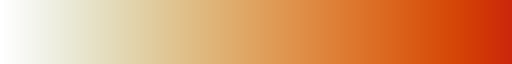

In [22]:
m2 = cmm.get_sub_cmap(cmm.sunburst_r, 0, 0.5)
m2

In [23]:
max_count = np.max([h.data_2D for h in hists])

In [24]:
max_count

65535.0

Trial values: peak_distance 7.412e-02 fwhm 3.889e-02 
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3891214704819601, 'h_fwhm': 0.036416859657251166, 'h_centroid': -0.005149411822478328, 'h_peak': -0.06795646132468734, 'v_sigma': 0.45603944914847, 'v_fwhm': 0.013655334114889284, 'v_centroid': 0.008084831705597068, 'v_peak': -0.029586557248925432, 'integral_intensity': 287.21027096965713, 'peak_intensity': 44548.223, 'gaussian_fit': {}}}


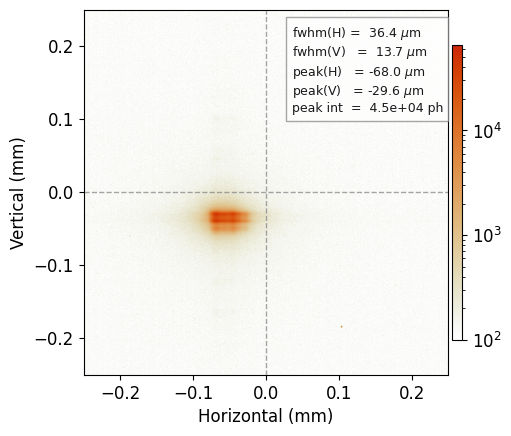

In [25]:
print(f"Trial values: peak_distance {study.trials[0].values[0]:4.3e} fwhm {study.trials[0].values[1]:4.3e} ")
print("Trial dw:")
print(study.trials[0].user_attrs["dw"].__dict__)

dwd= dict(**study.trials[0].user_attrs["dw"]._DictionaryWrapper__dictionary)


plt.figure(figsize=[5,5], constrained_layout=True)
plt.pcolormesh(hists[0].hh, hists[0].vv, hists[0].data_2D.T[::-1], cmap=m2, 
               norm=mpl.colors.LogNorm(100, max_count), rasterized=True)
plt.xlim(-0.25,0.25)
plt.ylim(-0.25,0.25)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
#plt.title("Initial")
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')

text = (fr"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
        fr"{'fwhm(V)':<9} = {dwd['v_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
        fr"{'peak(H)':<9} = {dwd['h_peak'] * 1000: 2.1f} $\mu$m" + "\n"
        fr"{'peak(V)':<9} = {dwd['v_peak'] * 1000: 2.1f} $\mu$m" + "\n"
        fr"{'peak int':<9} = {dwd['peak_intensity']: 3.1e} ph")
ax.text(0.035, 0.11, text, color='black', alpha=0.9, fontsize=9,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))
plt.savefig(f'{out_dir}/reference_same_as_initialization.svg', bbox_inches='tight', dpi=600)
plt.show()

In [26]:
nash_trial, nash_idx, n_doms = analysis.select_nash_equil_trial_from_pareto_front(study)

In [27]:
print(n_doms)
print(nash_trial.number, nash_trial.values)
print(nash_trial.user_attrs["dw"].__dict__)
print("Actual fwhm (not with reference)", opt_common._get_fwhm_from_dw(nash_trial.user_attrs["dw"]))

[128, 144, 74, 142]
83 [0.0022991581379456076, 0.010281921579573678]
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.38943231529145483, 'h_fwhm': 0.008453913849004735, 'h_centroid': 0.0011973220272326612, 'h_peak': -0.0022760537285780058, 'v_sigma': 0.45632146129905654, 'v_fwhm': 0.0058522860492382645, 'v_centroid': 0.005934315588865258, 'v_peak': 0.0003251270027353485, 'integral_intensity': 286.68511159490856, 'peak_intensity': 65442.863, 'gaussian_fit': {}}}
Actual fwhm (not with reference) 0.010281921579573678


Trial number 62
Trial values: peak_distance 4.598e-04 fwhm 1.444e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.3892906873125694, 'h_fwhm': 0.008453913849004735, 'h_centroid': 0.0013383477421216317, 'h_peak': -0.00032515053265395866, 'v_sigma': 0.45620272153959684, 'v_fwhm': 0.011704572098476529, 'v_centroid': 0.005691214406923217, 'v_peak': 0.0003251270027353485, 'integral_intensity': 286.9330095527904, 'peak_intensity': 58048.715, 'gaussian_fit': {}}}


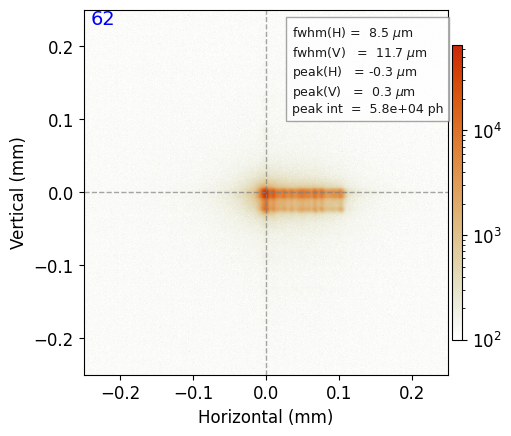

Trial number 83
Trial values: peak_distance 2.299e-03 fwhm 1.028e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.38943231529145483, 'h_fwhm': 0.008453913849004735, 'h_centroid': 0.0011973220272326612, 'h_peak': -0.0022760537285780058, 'v_sigma': 0.45632146129905654, 'v_fwhm': 0.0058522860492382645, 'v_centroid': 0.005934315588865258, 'v_peak': 0.0003251270027353485, 'integral_intensity': 286.68511159490856, 'peak_intensity': 65442.863, 'gaussian_fit': {}}}


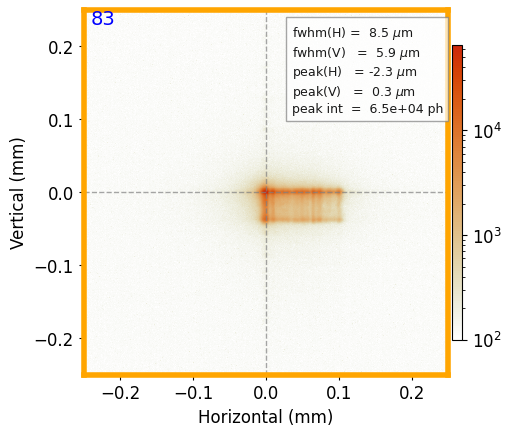

Trial number 89
Trial values: peak_distance 2.575e-02 fwhm 1.016e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.38936594225028803, 'h_fwhm': 0.0078036127836966784, 'h_centroid': -0.00048685750186083787, 'h_peak': -0.017883279295970386, 'v_sigma': 0.45630904732723326, 'v_fwhm': 0.006502540054709183, 'v_centroid': 0.007293519986659447, 'v_peak': -0.01853223915592033, 'integral_intensity': 286.94242751014224, 'peak_intensity': 64957.13, 'gaussian_fit': {}}}


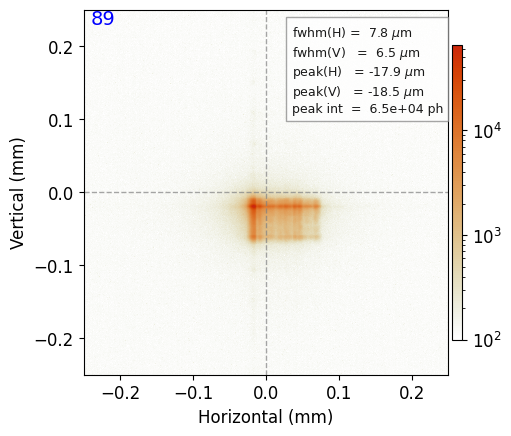

Trial number 150
Trial values: peak_distance 1.896e-03 fwhm 1.150e-02
Trial dw:
{'_DictionaryWrapper__dictionary': {'h_sigma': 0.38975957226596647, 'h_fwhm': 0.008453913849004735, 'h_centroid': 0.0009217042426718225, 'h_peak': -0.0016257526632700889, 'v_sigma': 0.4567274848340016, 'v_fwhm': 0.007803048065651019, 'v_centroid': 0.005985237293834794, 'v_peak': -0.000975381008206341, 'integral_intensity': 286.5060892159361, 'peak_intensity': 64079.8, 'gaussian_fit': {}}}


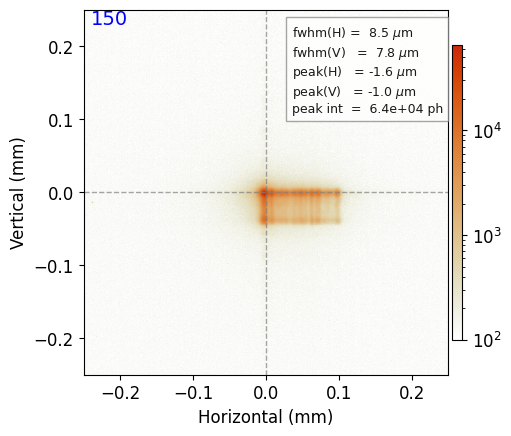

In [28]:
best_hists = []
for t in study.best_trials:
    print("Trial number", t.number)
    print(f"Trial values: peak_distance {t.values[0]:4.3e} fwhm {t.values[1]:4.3e}")
    print("Trial dw:")
    print(t.user_attrs["dw"].__dict__)
    
    
    dwd= dict(t.user_attrs["dw"]._DictionaryWrapper__dictionary)
    

    plt.figure(figsize=[5,5], constrained_layout=True)
    plt.pcolormesh(hists[t.number].hh, hists[t.number].vv, hists[t.number].data_2D.T[::-1], cmap=m2, 
                   norm=mpl.colors.LogNorm(100, max_count), rasterized=True)
    plt.xlim(-0.25,0.25)
    plt.ylim(-0.25,0.25)
    plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
    plt.xlabel('Horizontal (mm)')
    plt.ylabel('Vertical (mm)')
    #plt.title(t.number)
    plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

    ax = plt.gca()
    ax.set_aspect('equal')

    text = (fr"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
            fr"{'fwhm(V)':<9} = {dwd['v_fwhm'] * 1000: 2.1f} $\mu$m" + "\n"
            fr"{'peak(H)':<9} = {dwd['h_peak'] * 1000: 2.1f} $\mu$m" + "\n"
            fr"{'peak(V)':<9} = {dwd['v_peak'] * 1000: 2.1f} $\mu$m" + "\n"
            fr"{'peak int':<9} = {dwd['peak_intensity']: 3.1e} ph")
    #ax.text(0.035, 0.11, text, color='black', alpha=0.9, fontsize=9,
    ax.text(0.035 , 0.11, text, color='black', alpha=0.9, fontsize=9,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))
    plt.text(-0.24, 0.23, t.number, fontsize=14, color='blue')
    plt.savefig(f'{out_dir}/pareto_{t.number}.svg', bbox_inches='tight', dpi=600)
    if t.number == nash_trial.number:
        for axis in ['top','bottom','left','right']:
            plt.gca().spines[axis].set_linewidth(4)
            plt.gca().spines[axis].set_color('orange')
    plt.show()

In [29]:
study.best_trials[0].values

[0.00045981565522807544, 0.014438340187668017]

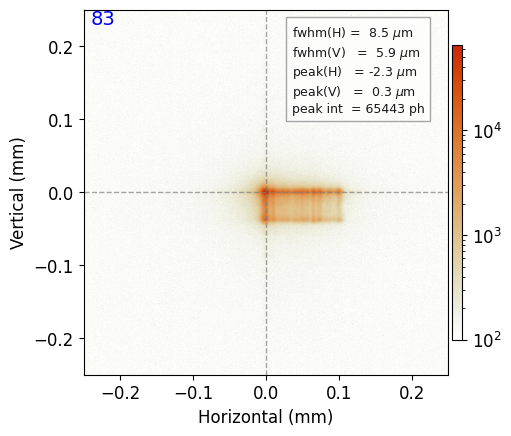

In [30]:

tnum = nash_trial.number
dwd = dict(**study.trials[tnum].user_attrs["dw"]._DictionaryWrapper__dictionary)

hist = hists[tnum]
plt.figure(figsize=[5,5], constrained_layout=True)
plt.pcolormesh(hist.hh, hist.vv, hist.data_2D.T[::-1], cmap=m2, 
               norm=mpl.colors.LogNorm(100, max_count), rasterized=True)
plt.xlim(-0.25,0.25)
plt.ylim(-0.25,0.25)
plt.axhline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.axvline(0, color='gray', ls='--', linewidth=1, alpha=0.7)
plt.xlabel('Horizontal (mm)')
plt.ylabel('Vertical (mm)')
#plt.title(t.number)
plt.colorbar(pad=0.01, aspect=30, shrink=0.6)

ax = plt.gca()
ax.set_aspect('equal')


text = (fr"{'fwhm(H)':<6} = {dwd['h_fwhm'] * 1000: 3.1f} $\mu$m" + "\n"
             fr"{'fwhm(V)':<9} = {dwd['v_fwhm']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak(H)':<9} = {dwd['h_peak']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak(V)':<9} = {dwd['v_peak']* 1000: 3.1f} $\mu$m" + "\n"
             fr"{'peak int':<9} = {dwd['peak_intensity']:3.0f} ph")
ax.text(0.035, 0.11, text, color='black', alpha=0.9, fontsize=9,
        bbox=dict(facecolor='white', edgecolor='gray', alpha=0.7))
plt.text(-0.24, 0.23, tnum, fontsize=14, color='blue')
plt.savefig(f'{out_dir}/pareto_hh.svg', bbox_inches='tight', dpi=600)
plt.show()

In [31]:
pareto_df = analysis.get_pareto_dataframe_from_study(study, ['peak_distance', 'fwhm'])

In [32]:
pareto_df

,number,peak_distance,fwhm,h_peak,v_peak,h_fwhm,v_fwhm,peak_intensity
62,62,0.000460,0.014438,-0.000325,0.000325,0.008454,0.011705,58048.714844
83,83,0.002299,0.010282,-0.002276,0.000325,0.008454,0.005852,65442.863281
89,89,0.025754,0.010158,-0.017883,-0.018532,0.007804,0.006503,64957.128906
150,150,0.001896,0.011505,-0.001626,-0.000975,0.008454,0.007803,64079.800781


In [33]:
c1 = [nash_trial.number]
c2 = [t.number for t in study.best_trials if t.number not in c1]
c3 = [n for n in range(len(hists)) if n not in c1 and n not in c2]


In [34]:
c2

[62, 89, 150]

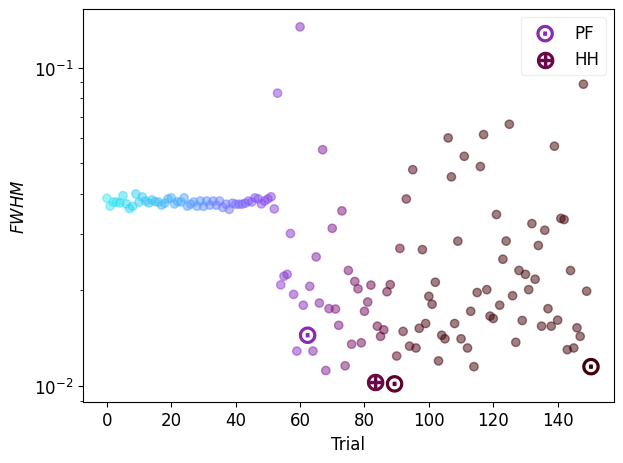

In [35]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values



plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[1] for t in study.trials])

plt.scatter(x[c3],y[c3], c=c3, cmap=cmm.gem_r, marker='o', alpha=0.5, norm=mpl.colors.Normalize(0,100))
plt.scatter(x[c2],y[c2], c=c2, cmap=cmm.gem_r, marker=r'$\odot$', s=175, norm=mpl.colors.Normalize(0, 100), label='PF')
plt.scatter(x[c1],y[c1], c=c1, cmap=cmm.gem_r, marker=r'$\oplus$', s=175, norm=mpl.colors.Normalize(0,100), label='HH')

plt.xlabel('Trial')
plt.ylabel('$FWHM$')
plt.yscale('log')
#for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
#plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
#plt.axvline(nash_trial.number, color='orange', label='HH')
plt.legend(loc="best", framealpha=0.3)
plt.tight_layout()
plt.show()

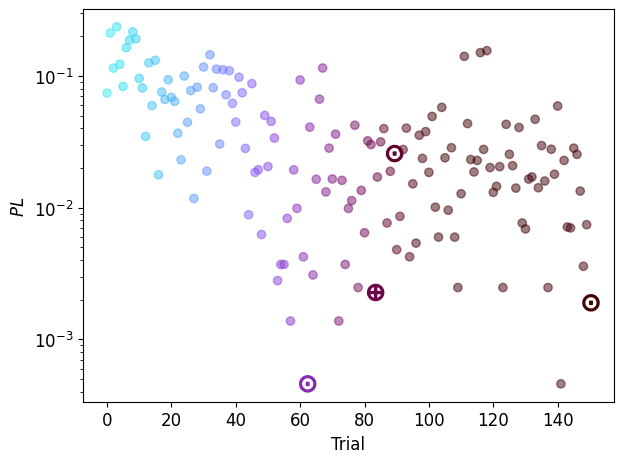

In [36]:
# Plotting the optimization histories
#optuna.visualization.matplotlib.plot_optimization_history(study, target=lambda t: t.values[0], target_name="$f_3$")
#plt.scatter(study.trials.values
plt.figure()
x = np.array([t.number for t in study.trials])
y = np.array([t.values[0] for t in study.trials])

plt.scatter(x[c3],y[c3], c=c3, cmap=cmm.gem_r, marker='o', alpha=0.5, norm=mpl.colors.Normalize(0,100))
plt.scatter(x[c2],y[c2], c=c2, cmap=cmm.gem_r, marker=r'$\odot$', s=175, norm=mpl.colors.Normalize(0, 100), label='PF')
plt.scatter(x[c1],y[c1], c=c1, cmap=cmm.gem_r, marker=r'$\oplus$', s=175, norm=mpl.colors.Normalize(0,100), label='HH')

plt.xlabel('Trial')
plt.ylabel('$PL$')
plt.yscale('log')
#for t in study.best_trials[:-1]:
#    plt.axvline(t.number, color='red', ls=':')
#plt.axvline(study.best_trials[-1].number, color='red', ls=':', label='PT')
#plt.axvline(nash_trial.number, color='orange', label='HH')
plt.tight_layout()
plt.show()

In [37]:
ground = {'peak_distance': 6.048e-3, 'fwhm': 1.965e-3}

In [38]:
ntrials = len(study.trials)

4.461371181393227 4.352882222222223


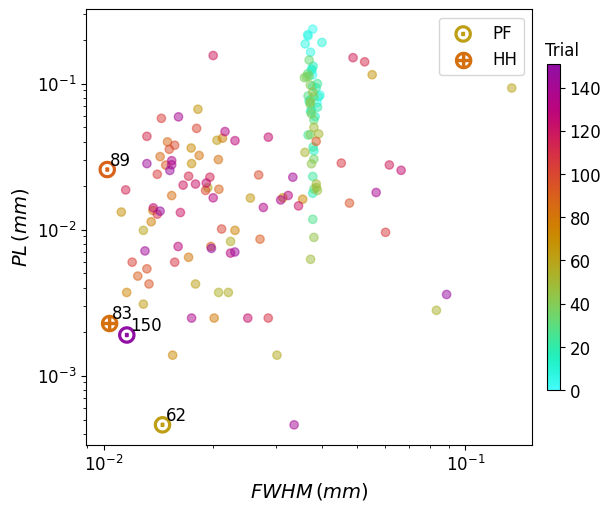

In [39]:

x = np.array([t.values[1] for t in study.trials])
y = np.array([t.values[0] for t in study.trials])

fig = plt.figure(figsize=[6,5],constrained_layout=True)
plt.scatter(x[c3],y[c3], c=c3, cmap=cmm.tropical_r, marker='o', alpha=0.5, norm=mpl.colors.Normalize(0,ntrials))
plt.scatter(x[c2],y[c2], c=c2, cmap=cmm.tropical_r, marker=r'$\odot$', s=175, norm=mpl.colors.Normalize(0, ntrials), label='PF')
plt.scatter(x[c1],y[c1], c=c1, cmap=cmm.tropical_r, marker=r'$\oplus$', s=175, norm=mpl.colors.Normalize(0,ntrials), label='HH')

for t in study.best_trials:
    plt.annotate(t.number, xy=(x[t.number], y[t.number]), xytext=(3, 3), textcoords='offset points')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$FWHM\,(mm)$', fontsize=14)
plt.ylabel('$PL\,(mm)$', fontsize=14)
cbar = plt.colorbar(pad=0.03, aspect=25, shrink=0.75, location='right')
#cbar.ax.set_ylabel('Trial')
cbar.ax.text(-0.1, 155.0,'Trial')
#cbar.ax.set_xlabel('Trial')#, fontsize=14)

#plt.scatter(ground['fwhm'], ground['peak_distance'], color='red', marker='*', s=175, label='M')
plt.legend(loc='best')
r = fig.canvas.get_renderer()
ax = plt.gca()

fig.execute_constrained_layout()
print(ax.bbox.width / fig.dpi, ax.bbox.height / fig.dpi)
plt.savefig(f'{out_dir}/pareto_fwhm_pl.svg', bbox_inches='tight', dpi=600)
plt.show()